###### Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [43]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.pipeline import Pipeline
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [44]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [45]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [46]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Cleaning**

**Portfolio Data**

In [47]:
# Converting channels into categories, dropping email since this is common to all channels
portfolio = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
portfolio.drop(['channels', 'email'], axis=1, inplace=True)

In [48]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1


In [49]:
# Changing column order 
portfolio = portfolio[['id', 'difficulty', 'reward', 'duration', 'offer_type', 
                       'mobile', 'web', 'social']]

In [50]:
portfolio.head()

,id,difficulty,reward,duration,offer_type,mobile,web,social
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1,0,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,discount,0,1,0


In [51]:
# Get dummies for offer_type and removing original column
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type))
portfolio.drop(['offer_type'], axis=1, inplace=True)

In [52]:
portfolio.head()

,id,difficulty,reward,duration,mobile,web,social,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,1,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,0,1,0,0,1,0


**2. Profile Data**

In [53]:
# getting dummies for gender, unknown "None" becomes baseline
profile = profile.join(pd.get_dummies(profile.gender))
#profile.drop(['gender'], axis=1, inplace=True)

In [54]:
profile.head()

,gender,age,id,became_member_on,income,F,M,O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,0,0,0


In [55]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [61]:
# converting to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')

In [64]:
profile['year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile['year']

0        2017
1        2017
2        2018
3        2017
4        2017
         ... 
16995    2018
16996    2018
16997    2017
16998    2016
16999    2017
Name: year, Length: 17000, dtype: int64

Text(0.5, 1.0, 'Date Distribution of when Users Joined')

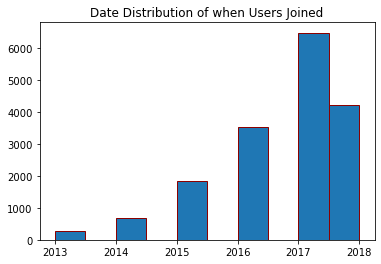

In [63]:
# Explore distribution of when users became members of Starbucks
x = list(profile['year'])
plt.hist(x, ec = 'darkred')
plt.title('Date Distribution of when Users Joined')

In [58]:
# rearranging column order
profile = profile[['id', 'gender','age', 'income', 'became_member_on', 'F', 'M', 'O']]

In [59]:
# renaming id column to person
profile.rename(columns={'id': 'person'}, inplace=True)

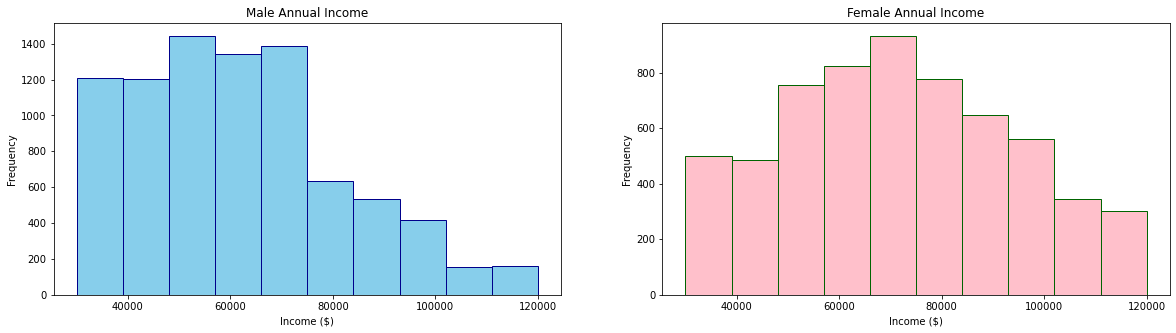

In [60]:
male = list(profile[profile['gender'] == 'M']['income'])
female = list(profile[profile['gender'] == 'F']['income'])

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(male, color = "skyblue", ec = "darkblue")
plt.xlabel('Income ($)')
plt.ylabel('Frequency')
plt.title('Male Annual Income')

plt.subplot(1, 2, 2)
plt.hist(female, color = "pink", ec = "darkgreen")
plt.xlabel('Income ($)')
plt.ylabel('Frequency')
plt.title('Female Annual Income')

plt.show()

In [41]:
profile.drop(['gender','year'], axis=1, inplace=True)
profile.head()

,person,age,income,became_member_on,F,M,O
0,68be06ca386d4c31939f3a4f0e3dd783,118,NaN,2017-02-12,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,2017-07-15,1,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,118,NaN,2018-07-12,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,2017-05-09,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,118,NaN,2017-08-04,0,0,0


**3. Transcript Data**

In [218]:
#merge profile and transcript
#transcript = transcript.merge(profile, on='person')
#transcript.head()

In [219]:
# Splitting out value column into two columns
transcript = transcript.join(pd.DataFrame(list(transcript.value)))
transcript.drop('value', axis=1, inplace=True)

In [220]:
# filling NaNs as blank strings across two column version of offer id
transcript['offer id'] = transcript['offer id'].fillna(value="")

In [221]:
transcript.head()

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [222]:
# concatenating offer id fields since raw data had differing naming conventions
#transcript['offer_id'] = transcript['offer id'].map(str) + transcript.offer_id.map(str)
#transcript.rename(columns={"offer id": "offer_id"}, inplace = True)

In [223]:
# remove redundant offer id column
transcript.drop('offer_id', axis=1, inplace=True)

In [224]:
transcript.rename(columns={"person": "customer_id"}, inplace = True)
transcript.rename(columns={"offer id": "offer_id"}, inplace = True)

In [225]:
transcript.head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [226]:
len(transcript)

306534

In [227]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [228]:
offers = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]
transactions = transcript[transcript.event == 'transaction']

In [229]:
offers.head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [230]:
transactions.head()

,customer_id,event,time,offer_id,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,,18.97,NaN


In [231]:
# Dropping columns
offers.drop(['amount'], axis=1, inplace = True)
transactions.drop(['event', 'offer_id'], axis=1, inplace = True)
offers.head()

C:\Users\shenl\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,customer_id,event,time,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [232]:
transactions.head()

,customer_id,time,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN


In [233]:
#get dummies for events and append to transcript
events = pd.get_dummies(offers['event'])
events.head()

,offer completed,offer received,offer viewed
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [234]:
events.rename(columns={"offer completed": "completed", "offer received": "received", "offer viewed": "viewed"}, inplace = True)

In [235]:
offers = pd.concat([offers, events], axis =1)
offers.head()

,customer_id,event,time,offer_id,reward,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0


In [236]:
offers.drop(['event'],axis =1, inplace = True)
offers.head()

,customer_id,time,offer_id,reward,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0


In [237]:
offers.viewed.value_counts()

0    109856
1     57725
Name: viewed, dtype: int64

In [238]:
#convert time to days from hours
offers['time_hour'] = offers['time']/24
transactions['time_hour'] = transactions['time']/24

<ipython-input-238-ec3a95165933>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['time_hour'] = transactions['time']/24


In [239]:
#transcript.drop(['time'], axis = 1, inplace = True)

In [240]:
#transcript.head()

In [241]:
offers.drop(['time'], axis = 1, inplace = True)
transactions.drop(['time'], axis = 1, inplace = True)

C:\Users\shenl\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [242]:
offers.head()


,customer_id,offer_id,reward,completed,received,viewed,time_hour
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0.0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0.0


In [243]:
transactions.head()

,customer_id,amount,reward,time_hour
12654,02c083884c7d45b39cc68e1314fec56c,0.83,NaN,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,NaN,0.0
12659,54890f68699049c2a04d415abc25e717,13.23,NaN,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,NaN,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,NaN,0.0


In [244]:
customer_id = '02c083884c7d45b39cc68e1314fec56c'
customer_offer = offers[offers['customer_id'] == customer_id]
customer_offer.head()

,customer_id,offer_id,reward,completed,received,viewed,time_hour
27,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,1,0,0.0
12653,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,0,1,0.0
150626,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,17.0


In [245]:
customer_offer = customer_offer.drop(columns = 'customer_id').reset_index(drop = True)
customer_offer.head()

,offer_id,reward,completed,received,viewed,time_hour
0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,1,0,0.0
1,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,0,1,0.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,17.0


In [246]:
received = customer_offer[customer_offer['received'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
received.head()

,offer_id,reward,time_hour
0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,17.0


In [247]:
viewed = customer_offer[customer_offer['viewed'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
viewed.head()

,offer_id,reward,time_hour
0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0.0


In [248]:
completed = customer_offer[customer_offer['completed'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
completed.head()

,offer_id,reward,time_hour


In [249]:
cur_offer_id = received.iloc[1]['offer_id']
cur_offer_id

'0b1e1539f2cc45b7b9fa7c272da2e1d7'

In [250]:
cur_offer = portfolio.loc[portfolio['id'] == cur_offer_id]
cur_offer

,id,difficulty,reward,duration,mobile,web,social,bogo,discount,informational
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,0,1,0,0,1,0


In [251]:
duration = cur_offer['duration'].values[0]
duration

10

**The function below creats new rows containing all purchase and offer information based on customer
and offer ids. Ideally, we want to separate transactions that occured due to an offer 
from transactions independent from an offer because the goal here 
is to identify the effectiveness of each offer.**

In [252]:
def get_success(customer_id, portfolio, profile, offers, transactions):
    """
    determine whether the offer was successfully redeemed by the customer.
    Input:
        customer_id: id of customer
        portfolio: portfolio dataframe
        profile: profile dataframe
        offers: dataframe with offer type and offer id.
        transactions: dataframe with transactions and amount
    Output:
        rows: list of dictionaries of successful offers.
    """
    
    customer = profile[profile['person'] == customer_id]
    
    customer_offer = offers[offers['customer_id'] == customer_id]
    customer_offer = customer_offer.drop(columns = 'customer_id').reset_index(drop = True)
    customer_trans = transactions[transactions['customer_id'] == customer_id]
    customer_trans = customer_trans.drop(columns = 'customer_id').reset_index(drop = True)
    
    received = customer_offer[customer_offer['received'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
    viewed = customer_offer[customer_offer['viewed'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
    completed = customer_offer[customer_offer['completed'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
    
    rows = []
    for idx in range(len(received)):

        # Initialize the current offer id
        cur_offer_id = received.iloc[idx]['offer_id']

        # Find current offer in portfolio
        cur_offer = portfolio.loc[portfolio['id'] == cur_offer_id]
        duration = cur_offer['duration'].values[0]

        # Time period when offer is valid
        startime = received.iloc[idx]['time_hour']

        endtime = received.iloc[idx]['time_hour'] + duration

        # Boolean array that falls in valid time window
        valid_transaction = np.logical_and(customer_trans['time_hour'] >=startime,
                           customer_trans['time_hour'] <= endtime)

        # Boolean array for completion of offer within time window
        valid_completed = np.logical_and(completed['time_hour'] >= startime,
                           completed['time_hour'] <= endtime)

        # Boolean array for viewing of offer within time window
        valid_viewed = np.logical_and(viewed['time_hour'] >= startime,
                           viewed['time_hour'] <= endtime)

        # Determine whether the current offer was successful
        success = valid_completed.sum() > 0 and valid_viewed.sum() > 0

        # Relevant customer transactions are ones that occurred within the current offer window
        relevant_transactions = customer_trans[valid_transaction]

        # Dictionary which describes the current customers offer
        cur_row = {'offerid': cur_offer_id,
                   'customerid': customer_id,
                   'time': startime,
                   'success': int(success),
                   'totalamount': relevant_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the success of an offer to the customer
        rows.append(cur_row)

    return rows

In [253]:
# Test to see if function works
customer_id = '02c083884c7d45b39cc68e1314fec56c'
test = pd.DataFrame(get_success(customer_id, portfolio, profile, offers, transactions))
test.head()

,offerid,customerid,time,success,totalamount,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,age,income,became_member_on,F,M,O
0,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,0.0,0,25.49,10,10,7,1,0,1,1,0,0,20,30000.0,2016-07-11,1,0,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,02c083884c7d45b39cc68e1314fec56c,17.0,0,3.18,20,5,10,0,1,0,0,1,0,20,30000.0,2016-07-11,1,0,0


In [255]:
# Using both offers and transactions, create new dataframe containing whether an offer worked or not 
starbucks_df = []
customerid_list = offers['customer_id'].unique()
for customer_id in customerid_list:
    starbucks_df.extend(get_success(customer_id, portfolio, profile, offers, transactions))

In [258]:
starbucks_df = pd.DataFrame(starbucks_df)
starbucks_df.head()

,offerid,customerid,time,success,totalamount,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,age,income,became_member_on,F,M,O
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,1,37.67,5,5,7,1,1,0,1,0,0,75,100000.0,2017-05-09,1,0,0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,0,49.39,0,0,3,1,0,1,0,0,1,75,100000.0,2017-05-09,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,1,48.28,10,10,7,1,0,1,1,0,0,75,100000.0,2017-05-09,1,0,0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,1,48.28,5,5,5,1,1,1,1,0,0,75,100000.0,2017-05-09,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0.0,0,1.09,20,5,10,0,1,0,0,1,0,118,NaN,2017-08-04,0,0,0


In [302]:
starbucks_df.isnull().sum()

offerid                0
customerid             0
time                   0
success                0
totalamount            0
difficulty             0
reward                 0
duration               0
mobile                 0
web                    0
social                 0
bogo                   0
discount               0
informational          0
age                    0
income              9776
became_member_on       0
F                      0
M                      0
O                      0
dtype: int64

In [303]:
starbucks_df = starbucks_df[starbucks_df['income'].notna()]

**Part III Machine learning Modeling**

In [304]:
# Split into training and testing data
features = starbucks_df[['duration','time','income','totalamount','bogo','discount','reward','informational','mobile','social','web', 'F','M','O']]
target = starbucks_df['success']

In [305]:
X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
X_train.head()

,duration,time,income,totalamount,bogo,discount,reward,informational,mobile,social,web,F,M,O
29712,7,7.0,52000.0,33.62,0,1,3,0,1,1,1,0,1,0
2360,7,7.0,101000.0,20.39,0,1,2,0,1,0,1,1,0,0
2212,7,0.0,64000.0,22.88,0,1,3,0,1,1,1,1,0,0
14133,10,7.0,35000.0,2.24,0,1,2,0,1,1,1,0,1,0
20085,4,24.0,36000.0,5.21,0,0,0,1,1,0,1,1,0,0


In [301]:
#X_train.isnull()

,duration,time,income,totalamount,bogo,discount,reward,informational,mobile,social,web,F,M,O
69676,False,False,False,False,False,False,False,False,False,False,False,False,False,False
51315,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62439,False,False,False,False,False,False,False,False,False,False,False,False,False,False
23326,False,False,False,False,False,False,False,False,False,False,False,False,False,False
71047,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6265,False,False,False,False,False,False,False,False,False,False,False,False,False,False
54886,False,False,True,False,False,False,False,False,False,False,False,False,False,False
860,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [306]:
X_train.isnull().sum()

duration         0
time             0
income           0
totalamount      0
bogo             0
discount         0
reward           0
informational    0
mobile           0
social           0
web              0
F                0
M                0
O                0
dtype: int64

In [292]:
#X_train = X_train[X_train['income'].notna()]


In [293]:
#X_train.isnull()

,duration,time,income,totalamount,bogo,discount,reward,informational,mobile,social,web,F,M,O
69676,False,False,False,False,False,False,False,False,False,False,False,False,False,False
51315,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62439,False,False,False,False,False,False,False,False,False,False,False,False,False,False
23326,False,False,False,False,False,False,False,False,False,False,False,False,False,False
71047,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60263,False,False,False,False,False,False,False,False,False,False,False,False,False,False
37194,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6265,False,False,False,False,False,False,False,False,False,False,False,False,False,False
860,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [297]:
#X_train.isnull().sum()

duration         0
time             0
income           0
totalamount      0
bogo             0
discount         0
reward           0
informational    0
mobile           0
social           0
web              0
F                0
M                0
O                0
dtype: int64

In [307]:
y_train.value_counts()

0    28137
1    25063
Name: success, dtype: int64

The difference between decision tree calssifier versus and random forest classifier models.

In [308]:
clf1 = DecisionTreeClassifier()                
clf2 = RandomForestClassifier()
classifier_list = [clf1,clf2]

I decided to look at the F1 score to determine which classifer to use.

𝐹1=2∗(𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛∗𝑟𝑒𝑐𝑎𝑙𝑙)/(𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛+𝑟𝑒𝑐𝑎𝑙𝑙) 
F1 scores are a measure that looks at both the precision and the recall of the classifer

In [309]:
clf_dict = {}
for clf in classifier_list:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = f1_score(y_test, y_pred)
    clf_dict[clf.__class__.__name__] = accuracy

In [310]:
print(clf_dict)

{'DecisionTreeClassifier': 0.8683420262367632, 'RandomForestClassifier': 0.8993172722278898}


**RandomForest model was selected since its F1 score is higher**

In [311]:
parameters = {#'clf__estimator__n_estimators': [10]
             'n_estimators': [5,10],
            'min_samples_split': [2,3,4]}
             #'clf__estimator__min_samples_split': [2,3]}

cv = GridSearchCV(estimator = clf2, param_grid = parameters)

In [312]:
cv.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': [2, 3, 4],
                         'n_estimators': [5, 10]})

In [313]:
print('Training F1_score:', cv.score(X_train,y_train))
print('Test F1_score:', cv.score(X_test,y_test))

Training F1_score: 0.9752067669172932
Test F1_score: 0.9011352529884971


In [314]:
cv.best_estimator_.feature_importances_

array([0.07361955, 0.02801018, 0.09335344, 0.65402562, 0.02340976,
       0.01254912, 0.04543096, 0.0320541 , 0.00421918, 0.01539478,
       0.00789843, 0.00360984, 0.0057077 , 0.00071735])

In [316]:
feature_importances = pd.DataFrame(cv.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
totalamount,0.654026
income,0.093353
duration,0.073620
reward,0.045431
informational,0.032054
time,0.028010
bogo,0.023410
social,0.015395
discount,0.012549
web,0.007898


In [317]:
feature_importances.importance

totalamount      0.654026
income           0.093353
duration         0.073620
reward           0.045431
informational    0.032054
time             0.028010
bogo             0.023410
social           0.015395
discount         0.012549
web              0.007898
M                0.005708
mobile           0.004219
F                0.003610
O                0.000717
Name: importance, dtype: float64

In [318]:
feature_importances.index

Index(['totalamount', 'income', 'duration', 'reward', 'informational', 'time',
       'bogo', 'social', 'discount', 'web', 'M', 'mobile', 'F', 'O'],
      dtype='object')

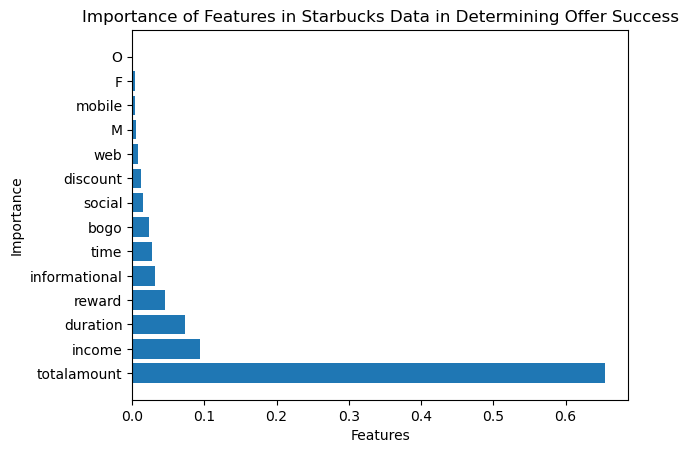

In [328]:
plt.rcdefaults()
fig, ax = plt.subplots()

imp_features = list(feature_importances.index)
y_pos = np.arange(len(imp_features))
importance = list(feature_importances.importance)

ax.barh(y_pos, importance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_features)
ax.set_ylabel('Importance')
ax.set_xlabel('Features')
ax.set_title('Importance of Features in Starbucks Data in Determining Offer Success')

plt.show()

**We can conclude from the figure that "Totalamount" spent has the most impact that affect 
the successful offer. "income" ranks the 2nd and "duration" ranks the 3rd.**

In [329]:
def save_data(model, model_filepath):
    '''
    Save model as a pickle file 
    Input: 
        model: evaluated model
        model_filepath: path of the output file
    Output:
        A pickle file of saved model
    '''
    pickle.dump(model, open(model_filepath, "wb"))

In [330]:
model_filepath = 'randomforestclassifer.pkl'
print('Saving model...\n    MODEL: {}'.format(model_filepath))
save_data(cv, model_filepath)

Saving model...
    MODEL: randomforestclassifer.pkl
